In [1]:
import jax
from jax import grad, jit, vmap
import jax.numpy as jnp
from jax.experimental.ode import odeint
import numpy as np

from matplotlib import pyplot as plt

In [2]:
def random_states(num_patterns, num_neurons, p):
    '''
    generate random patterns for memory
    ---
    parameters:
    p - scaler (0,1)
        the probability of Bernoulli distribution
    ---
    returns:
    a matrix of size (num_patterns, num_neurons) in -1s and 1s
    '''
    S = 2*np.random.binomial(n=1, p = p, size=(num_patterns, num_neurons))-1
    return jnp.array(S)

@jit
def similarity(S, z):
    '''
    Compute the similarity between patterns in S and query z
    ---
    parameters:
    S - (num_patterns, num_neruons)
        patterns stored in model
    z - (num_neuros,)
        query vector
    ---
    returns:
    a similarity vector of (num_patterns,) in [0,1]
    '''
    return S @ z.T / S.shape[1]

@jit
def outer_learning(S):
    '''
    Compute the weight matrix with Hebbian outer product rule
    ---
    parameters:
    S - (num_patterns, num_neruons)
        patterns stored in model
    ---
    returns:
    a weight matrix of size (num_neurons, num_neurons)
    '''
    return S.T @ S / S.shape[0] - jnp.eye(S.shape[1])


def activation(u, gain=1.0): 
    return jnp.tanh(gain * u) # can be sigmoid or tanh


@jit
def hopfield_dynamics(u, t, W, I, tau=1.0, gain=1.0):
    '''
    Compute the Hopfield dynamics
    
    '''
    v = activation(u, gain)
    du_dt = (-u + W @ v + I) / tau
    return du_dt


In [3]:
n_patterns = 2
n_neurons = 20

t0 = 0
t1 = 0.5
n_steps = 500
times = jnp.linspace(t0, t1, n_steps)

S = random_states(n_patterns, n_neurons, 0.5)
W = outer_learning(S)
I = jnp.zeros(n_neurons)

# Set initial state as noisy version of the first pattern
u0 = S[0,:] + jnp.array((np.random.rand(n_neurons)*2-1))

In [4]:
# Similarity of the initial state to stored patterns
similarity(S, u0)

Array([0.9032504 , 0.34808037], dtype=float32)

In [5]:
sol = odeint(
    lambda state, t: hopfield_dynamics(state, t, W, I),
    u0,
    times
)
v = jnp.tanh(sol)

In [6]:
# Similarity of the final state to stored patterns
similarity(S,v[-1,:])

Array([0.9964172 , 0.20338301], dtype=float32)

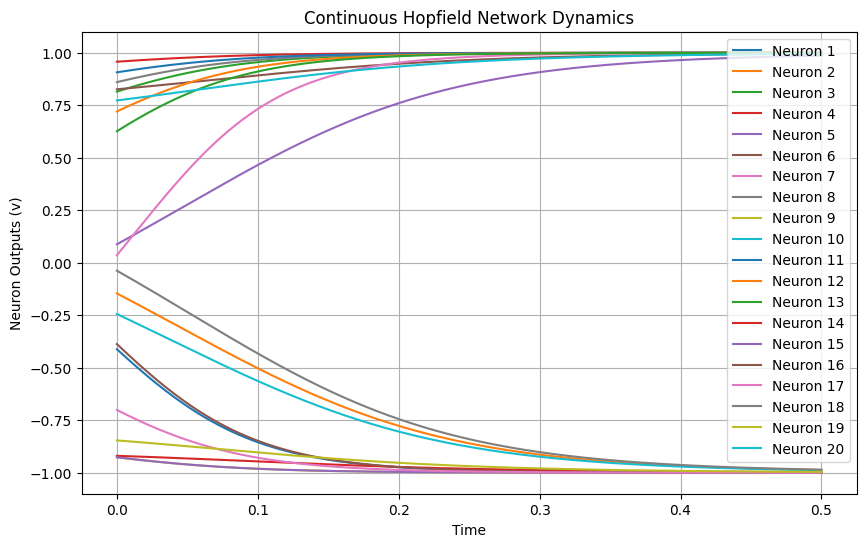

In [7]:
plt.figure(figsize=(10, 6))
for i in range(n_neurons):
    plt.plot(times, v[:, i], label=f'Neuron {i+1}')
plt.xlabel('Time')
plt.ylabel('Neuron Outputs (v)')
plt.title('Continuous Hopfield Network Dynamics')
plt.legend()
plt.grid(True)
plt.show()